In [103]:
allow_train = True
freeze_encoder = False
EPOCHS = 10
BATCH_SIZE = 32
shrink_size = 200

lr = 0.1
weight_deacay = 1e-4
T_max = 15
eta_min = 0.001

In [93]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR

from going_modular import engine_post_train, utils
from going_modular import custom_data_setup_post_train
import helper_functions

In [94]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [95]:
no_transforms = helper_functions.get_augmentation_no_transforms()

In [96]:
train_val_dataloader, class_names = custom_data_setup_post_train.create_train_val_dataloader(transform=no_transforms, batch_size=BATCH_SIZE, device=device, shrink_size=shrink_size)

test_dataloader, class_names = custom_data_setup_post_train.create_test_dataloader(transform=no_transforms, batch_size=BATCH_SIZE, device=device, shrink_size=shrink_size)

exp_dataloader, class_names = custom_data_setup_post_train.create_train_dataloader(transform=no_transforms, batch_size=BATCH_SIZE, device=device, shrink_size=shrink_size)

d:\University Project\University-Project-Code\University-Project-Code\going_modular\custom_data_setup_post_train.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.l

In [97]:
class OneHeadCNN(nn.Module):
    def __init__(self):
        super(OneHeadCNN, self).__init__()

        self.final_head = nn.Sequential(
            # nn.Linear(3, 10),
            # nn.ReLU(),
            # nn.Linear(10, 5),
            # nn.ReLU(),
            # nn.Linear(5, 3),
            # nn.ReLU(),
            nn.Linear(3, 1)
        )
        
    def forward(self, x):
        return self.final_head(x)

model = OneHeadCNN().to(device)

In [98]:
# Initialize all weights to 1/3
def init_weights_custom(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 1/3)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

model.apply(init_weights_custom)

OneHeadCNN(
  (final_head): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
  )
)

In [99]:
# Define loss and optimizer

loss_fn = nn.MSELoss().to(device)

optimizer = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_deacay)
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

In [104]:
folds_train_results = {
    'loss_train': []
}
folds_val_results = {
    'loss_val': []
}
if allow_train:
    # Set the random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results
    for fold in train_val_dataloader:
        train_results, val_results = engine_post_train.train(model=model,
                            train_dataloader=fold['train_dataloader'],
                            val_dataloader=fold['val_dataloader'],
                            optimizer=optimizer,
                            scheduler=scheduler,
                            loss_fn=loss_fn,
                            epochs=EPOCHS,
                            device=device)
        
        folds_train_results['loss_train'].extend(train_results['loss_train'])

        folds_val_results['loss_val'].extend(val_results['loss_val'])

    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    utils.save_model(model=model, target_dir='models', model_name='post_train_model.pth')
else:
    model.load_state_dict(torch.load('models/post_train_model.pth', weights_only=True, map_location=device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
loss_train: 1.6232 | loss_val: 1.4427 | acc_val: 0.5000

Epoch: 2
loss_train: 1.5918 | loss_val: 1.7886 | acc_val: 0.4688

Epoch: 3
loss_train: 1.6605 | loss_val: 1.3298 | acc_val: 0.2656

Epoch: 4
loss_train: 1.9773 | loss_val: 2.3395 | acc_val: 0.0312

Epoch: 5
loss_train: 1.8384 | loss_val: 1.6696 | acc_val: 0.2812

Epoch: 6
loss_train: 1.6383 | loss_val: 1.7726 | acc_val: 0.3281

Epoch: 7
loss_train: 1.7801 | loss_val: 1.7937 | acc_val: 0.3281

Epoch: 8
loss_train: 1.7006 | loss_val: 1.5967 | acc_val: 0.2969

Epoch: 9
loss_train: 2.0827 | loss_val: 2.1946 | acc_val: 0.1250

Epoch: 10
loss_train: 1.8926 | loss_val: 3.4507 | acc_val: 0.0312



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
loss_train: 3.2266 | loss_val: 1.2857 | acc_val: 0.2188

Epoch: 2
loss_train: 2.2304 | loss_val: 1.8366 | acc_val: 0.2656

Epoch: 3
loss_train: 2.0737 | loss_val: 1.2057 | acc_val: 0.2500

Epoch: 4
loss_train: 1.7766 | loss_val: 1.6450 | acc_val: 0.2500

Epoch: 5
loss_train: 2.2136 | loss_val: 3.8400 | acc_val: 0.0000

Epoch: 6
loss_train: 2.5435 | loss_val: 1.6690 | acc_val: 0.1875

Epoch: 7
loss_train: 1.6895 | loss_val: 1.7870 | acc_val: 0.2656

Epoch: 8
loss_train: 1.8962 | loss_val: 1.0420 | acc_val: 0.2969

Epoch: 9
loss_train: 1.7237 | loss_val: 1.3380 | acc_val: 0.1875

Epoch: 10
loss_train: 1.7040 | loss_val: 1.5066 | acc_val: 0.2500



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
loss_train: 1.7764 | loss_val: 2.1457 | acc_val: 0.1406

Epoch: 2
loss_train: 1.9861 | loss_val: 1.7685 | acc_val: 0.2344

Epoch: 3
loss_train: 1.8414 | loss_val: 1.8062 | acc_val: 0.1562

Epoch: 4
loss_train: 1.6825 | loss_val: 1.4642 | acc_val: 0.1562

Epoch: 5
loss_train: 1.6871 | loss_val: 1.1651 | acc_val: 0.3125

Epoch: 6
loss_train: 1.6061 | loss_val: 1.7225 | acc_val: 0.3125

Epoch: 7
loss_train: 1.8484 | loss_val: 2.0255 | acc_val: 0.0938

Epoch: 8
loss_train: 1.9056 | loss_val: 1.6061 | acc_val: 0.1875

Epoch: 9
loss_train: 1.7913 | loss_val: 1.6133 | acc_val: 0.1250

Epoch: 10
loss_train: 1.7520 | loss_val: 1.4914 | acc_val: 0.2031



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
loss_train: 1.5496 | loss_val: 1.4810 | acc_val: 0.3125

Epoch: 2
loss_train: 1.4914 | loss_val: 1.9160 | acc_val: 0.3125

Epoch: 3
loss_train: 1.5407 | loss_val: 1.5348 | acc_val: 0.2188

Epoch: 4
loss_train: 1.5514 | loss_val: 1.9531 | acc_val: 0.2188

Epoch: 5
loss_train: 1.5534 | loss_val: 1.9404 | acc_val: 0.3125

Epoch: 6
loss_train: 1.5361 | loss_val: 1.9045 | acc_val: 0.2031

Epoch: 7
loss_train: 1.5125 | loss_val: 1.8815 | acc_val: 0.2031

Epoch: 8
loss_train: 1.4984 | loss_val: 2.0838 | acc_val: 0.2188

Epoch: 9
loss_train: 1.5171 | loss_val: 2.3345 | acc_val: 0.2188

Epoch: 10
loss_train: 1.5815 | loss_val: 2.0797 | acc_val: 0.2188



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
loss_train: 1.6638 | loss_val: 1.6073 | acc_val: 0.3750

Epoch: 2
loss_train: 1.6001 | loss_val: 1.8056 | acc_val: 0.2500

Epoch: 3
loss_train: 1.5592 | loss_val: 1.5765 | acc_val: 0.2500

Epoch: 4
loss_train: 1.5595 | loss_val: 1.2275 | acc_val: 0.3438

Epoch: 5
loss_train: 1.5833 | loss_val: 1.9830 | acc_val: 0.4062

Epoch: 6
loss_train: 1.6440 | loss_val: 2.1029 | acc_val: 0.1406

Epoch: 7
loss_train: 1.7519 | loss_val: 1.3290 | acc_val: 0.4688

Epoch: 8
loss_train: 1.5682 | loss_val: 1.5429 | acc_val: 0.2969

Epoch: 9
loss_train: 1.5547 | loss_val: 1.3372 | acc_val: 0.2969

Epoch: 10
loss_train: 1.5521 | loss_val: 1.9632 | acc_val: 0.1562

[INFO] Total training time: 0.224 seconds
[INFO] Saving model to: models\post_train_model.pth


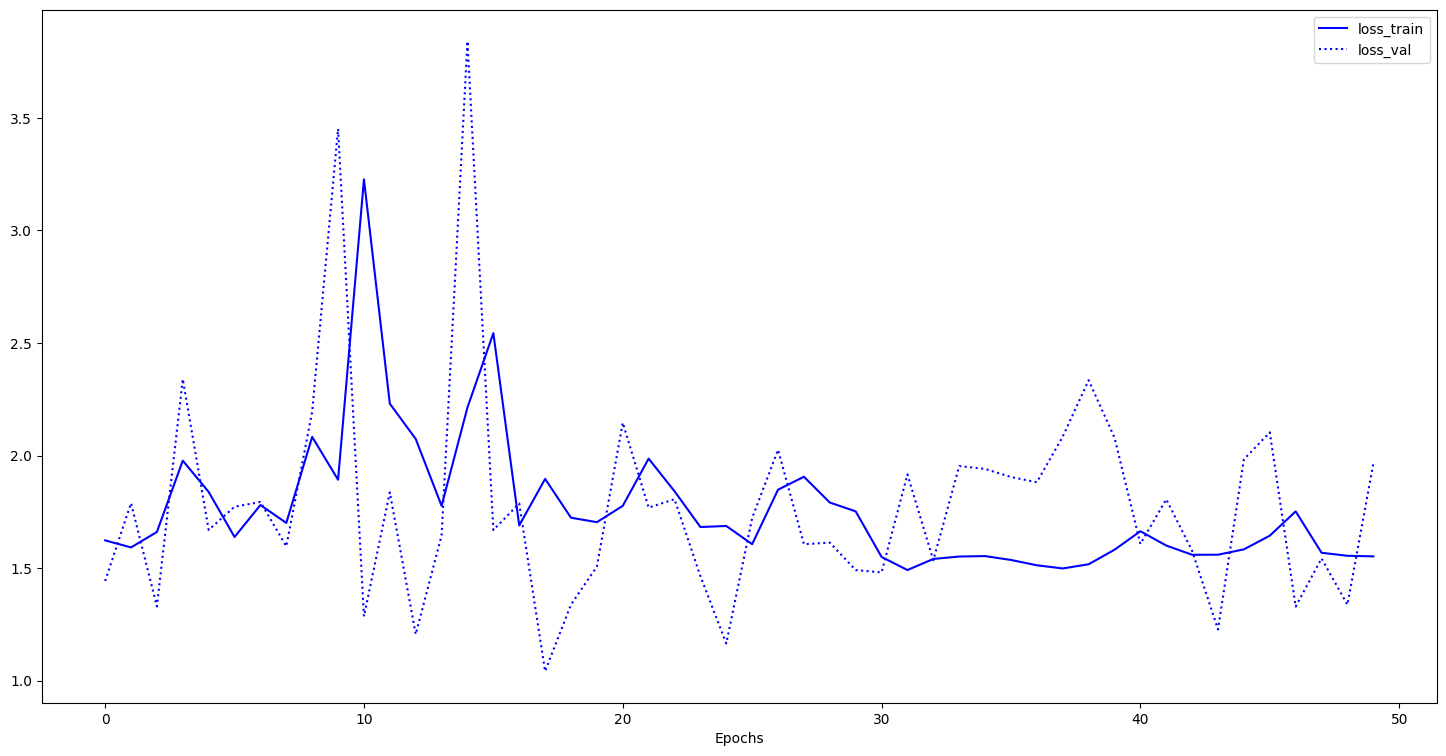

In [105]:
if allow_train:
    helper_functions.plot_loss_curves_post_train(folds_train_results, folds_val_results)

In [106]:
test_results = engine_post_train.test_step(
    model=model,
    dataloader=exp_dataloader,
    loss_fn=loss_fn,
    device=device)

test acc: 0.2544642857142857
